# Job Description Analysis

This notebook aims to analyse the data collected from the jobs searches webscraping files.

Firstly, the data needs to be cleaned. Cleaning that can be done for each job search is removing duplicates. Then the data can be filtered to remove jobs without salaries, etc.

Then the data can be analysed for jobs by region, by salary etc. We can also apply Natural Language Processing (NLP) to the full job description. This can allow us to get an overview of wha the most common words across the job descriptions are, run sentiment analysis, group the data into topics, find what a computer considers the most average job description by the word vectors.

### Import packages 

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pylab as plt
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS as nltk_STOPS
from gensim.test.utils import datapath
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')
np.random.seed(400)
from wordcloud import WordCloud,STOPWORDS

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hworr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Parameters

In [2]:
min_word_occurence = 5
max_occurence_proportion = 0.5
number_topics = 20
text_cols = ["Job Description"]
output_filename = "junior developer, everywhere"

cwd = Path(os.getcwd())
models_path = Path(os.path.join(cwd, "models"))
bow_path = Path(os.path.join(models_path, "bag_of_words"))
lda_path = Path(os.path.join(models_path, "lda"))
references_path = Path(os.path.join(models_path, "references"))

In [3]:
# create a models folder unless it already exists
try:
    os.mkdir(models_path)
except OSError:
    print(f"Failed - 'models' folder probably already exists.")
else:
    print("New folder created.")

try:
    os.mkdir(bow_path)
except OSError:
    print(f"Failed - 'bag_of_words' folder probably already exists.")
else:
    print("New folder created.")

try:
    os.mkdir(lda_path)
except OSError:
    print(f"Failed - 'lda' folder probably already exists.")
else:
    print("New folder created.")


try:
    os.mkdir(references_path)
except OSError:
    print(f"Failed - 'references' folder probably already exists.")
else:
    print("New folder created.")

Failed - 'models' folder probably already exists.
Failed - 'bag_of_words' folder probably already exists.
Failed - 'lda' folder probably already exists.
Failed - 'references' folder probably already exists.


In [4]:
Path(os.getcwd())

WindowsPath('c:/Users/hworr/Documents/GitHub/JobsWebscraper')

### Load data


In [5]:
data = pd.read_csv('Monster Jobs webscrape for junior developer, everywhere.csv', encoding='utf-8')
print(data.shape)
data.head()

(2035, 6)


,Job Title,Company,Job Type,Location,Salary,Job Description
0,"Graduate / Junior Developer, Python, JavaScrip...",Noir,Full Time,"London, London",£35k - £50k Per Year,"Description\n\nGraduate / Junior Developer, Py..."
1,"Graduate / Junior Developer, Python, JavaScrip...",Noir,Full Time,"London, London",£35k - £50k Per Year,"Description\n\nGraduate / Junior Developer, Py..."
2,"Graduate / Junior Developer, Python, Linux, C#...",Noir,Full Time,"Birmingham, MID",£30k - £40k Per Year,"Description\n\nGraduate / Junior Developer, Py..."
3,"Graduate / Junior Developer, Python, Linux, C#...",Noir,Full Time,"Birmingham, MID",£30k - £40k Per Year,"Description\n\nGraduate / Junior Developer, Py..."
4,Junior Developer - C# / .Net / Angular,SEARCHABILITY,Full Time,"Sheffield, Yorkshire",£20k - £25k Per Year,Description\n\nJunior .NET Developer - Opportu...


### Clean Data

This first cell for dropping duplicate data can be applied to any webscrape.

In [6]:
data = data.drop_duplicates()
data = data.drop_duplicates(subset=['Job Title', 'Company','Job Description'])
data = data.drop_duplicates(subset=['Job Title', 'Company','Location','Salary'])
print(data.shape)
data.head()

(960, 6)


,Job Title,Company,Job Type,Location,Salary,Job Description
0,"Graduate / Junior Developer, Python, JavaScrip...",Noir,Full Time,"London, London",£35k - £50k Per Year,"Description\n\nGraduate / Junior Developer, Py..."
2,"Graduate / Junior Developer, Python, Linux, C#...",Noir,Full Time,"Birmingham, MID",£30k - £40k Per Year,"Description\n\nGraduate / Junior Developer, Py..."
4,Junior Developer - C# / .Net / Angular,SEARCHABILITY,Full Time,"Sheffield, Yorkshire",£20k - £25k Per Year,Description\n\nJunior .NET Developer - Opportu...
6,Junior Developer,myjobscotland,Full Time,"Fife, Scotland",NaN,Description\nDigital Services\nLocation to be ...
10,Graduate / Junior Web Engineer - OOP / LAMP - ...,Spectrum IT,Full Time,"Southampton, Southern",£25k - £27k Per Year,Description\n\nGraduate / Junior Engineer\n\nO...


## Text Modelling

In [7]:
# Define functions for pre processing
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Remove stopwords and words with 3 or less characters
        if token not in nltk_STOPS and len(token) > 3:
            # Apply the lemmatize_stemming function and add to results
            result.append(lemmatize_stemming(token))
    return result

In [8]:
# function to remove characters which cannot be part of file name
def remove_chars_to_save(string):
    bad_chars = ["/", "<", ">", ":", '"', "\\", "|", "?", "*"]
    for char in bad_chars:
        string = string.replace(char, " ")
    string = string.replace(" ", "_")
    return string

In [9]:
# define function to check save path
def check_save_path(root_folder, filename):
    path_length = len(str(Path(root_folder)/filename))
    if path_length > 251:
        length_over = path_length - 251
        # we want to remove length over characters from the path's file name
        # remove the number of characters over from the end of the filename, but not the file extension!
        return filename[:-(length_over+12)] + "..." + filename[-7:]
    else:
        return filename

In [10]:
# build bag of words model and dictionary
def build_bow(column_name):
    processed_docs = data[column_name].fillna("").map(preprocess)
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=min_word_occurence, no_above=max_occurence_proportion, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    save_name = remove_chars_to_save(column_name)
    save_name = check_save_path(bow_path, save_name)
    dictionary.save(datapath(bow_path/f'{save_name}.dict'))  # save dict to disk
    gensim.corpora.MmCorpus.serialize(datapath(bow_path/f'{save_name}.mm'), bow_corpus)  # save bow corpus to disk
    return bow_corpus, dictionary

# build lda model and save it function
def build_lda_model(column_name):
    bow = build_bow(column_name)
    bow_corpus = bow[0]
    dictionary = bow[1]
    try:
        lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                        num_topics=number_topics, 
                                        id2word = dictionary, 
                                        passes = 4, 
                                        workers=2)
        save_name = remove_chars_to_save(column_name)
        save_name = check_save_path(lda_path, save_name)
        file_path = datapath(lda_path/save_name)
        lda_model.save(file_path)
    except ValueError as error:
        print(f"Error! {error}")

# create reference for topics file
def create_reference(column_name):
    save_name = remove_chars_to_save(column_name)
    save_name = check_save_path(lda_path, save_name)
    try:
        lda_model = gensim.models.LdaModel.load(datapath(lda_path/save_name))
        save_name = remove_chars_to_save(column_name)
        save_name = check_save_path(references_path, save_name)
        with open(references_path/f"{save_name}_topics", 'w') as outfile:
            for idx, topic in lda_model.print_topics(-1):
                line = f"Topic: {idx}\nWords: {topic}\n\n"
                outfile.write(line)
    except FileNotFoundError as error:
        print(f"Error - no model! {error}")

In [11]:
for col in text_cols:
    build_lda_model(col)
    create_reference(col)

Dictionary in saved folder needs loading.  
Bow corpus needs loading.  
Bow corpus is list of lists containing tuples mapping onto word in the dictionary `[0]` --> dictionary word index; `[1]` --> frequency the word appears.  
Create a string which will be formed from joining the words of the dictionary at a given index together, ensuring that the word is add the number of times it appears in the frequency argument.
Use this string to plot the word cloud.

In [12]:
test_col = text_cols[0]
save_name = remove_chars_to_save(test_col)
bow_corpus = gensim.corpora.MmCorpus(datapath(bow_path/f'{save_name}.mm'))
dictionary = gensim.corpora.dictionary.Dictionary.load(datapath(bow_path/f'{save_name}.dict'))

In [13]:
wc_list = []
for document in bow_corpus:
    for mapping in document:
        for freq in range(int(mapping[1])):
            wc_list.append(dictionary[mapping[0]])
wc_string = " ".join(wc_list)

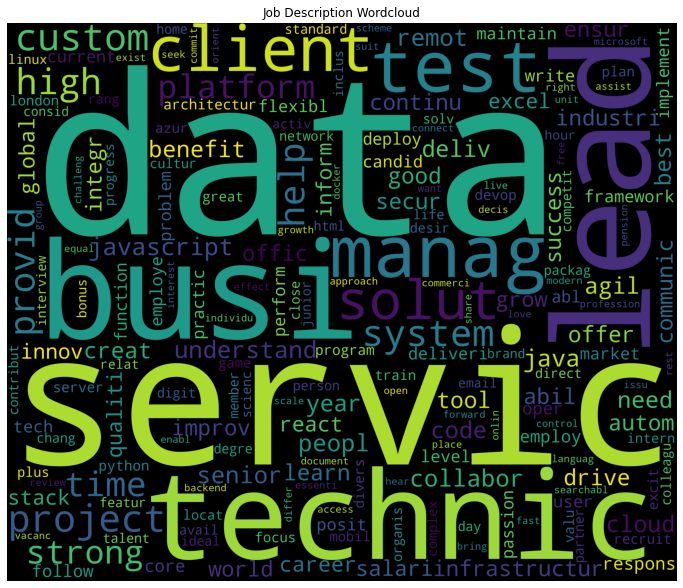

In [16]:
save_figures = True

wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        width=3000,
                        height=2500,
                        collocations=False
                        ).generate(wc_string)
plt.figure(1,figsize=(12, 12))
plt.title(f'{test_col} Wordcloud')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
if save_figures == True:
    save_name = remove_chars_to_save(test_col)
    save_name = check_save_path(cwd, save_name)
    wordcloud.to_file(cwd/f"{output_filename}_wordcloud.png")